# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

N         int64
P         int64
K         int64
ph      float64
crop     object
dtype: object
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    N   P   K        ph  crop
0  90  42  43  6.502985  rice
1  85  58  41  7.038096  rice
2  60  55  44  7.840207  rice
3  74  35  40  6.980401  rice
4  78  42  42  7.628473  rice
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
22
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
N       0
P       0
K       0
ph      0
crop    0
dtype: int64


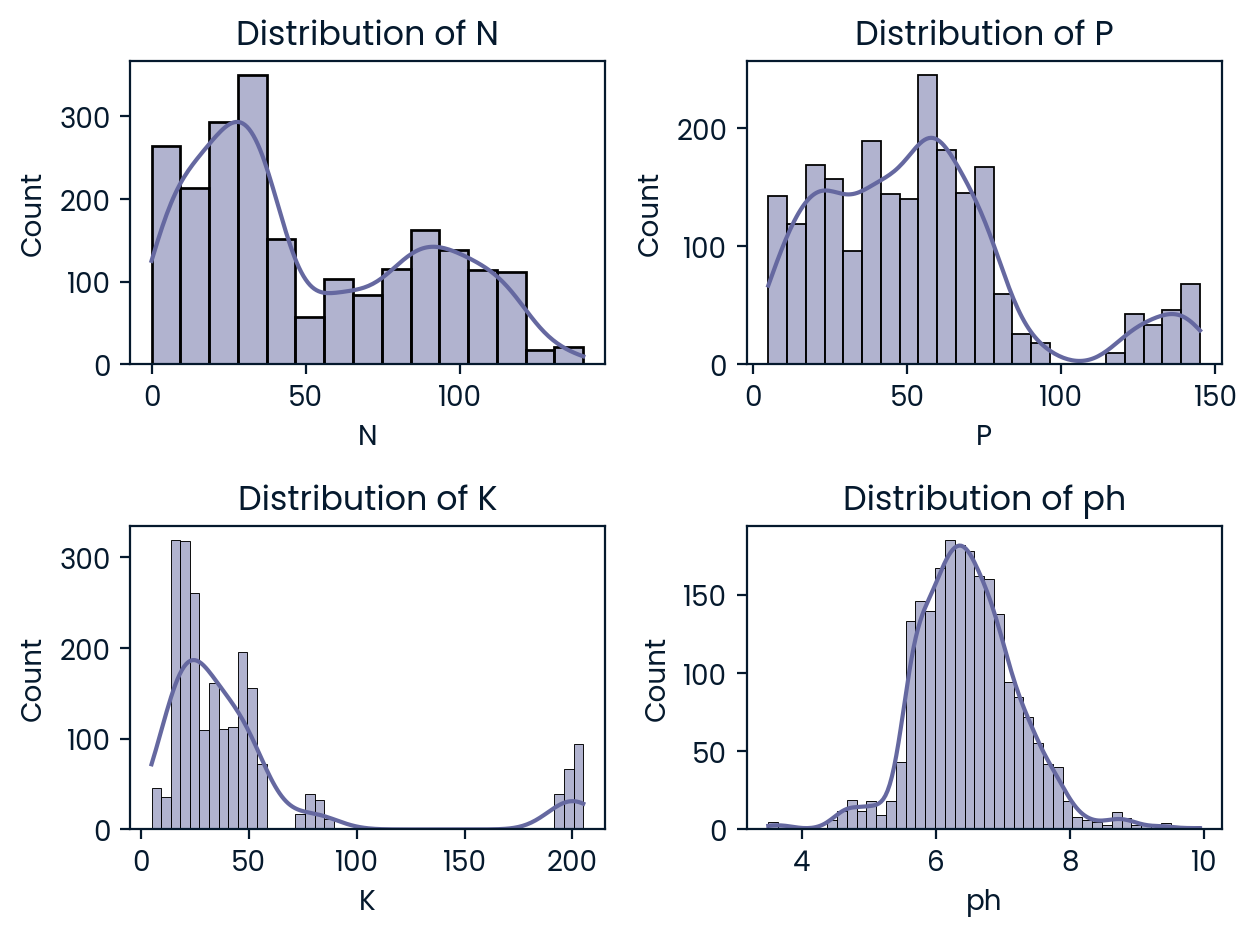

In [131]:
# Lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
crops = pd.read_csv("soil_measures.csv")
# understanding the data
print(crops.dtypes)
print("^"*30)
print(crops.head())
print("^"*30)
print(crops['crop'].nunique())
print("^"*30)
print(crops.isnull().sum())

columns = ['N', 'P', 'K', 'ph'] 
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()
for i, col in enumerate(columns):
    sns.histplot(crops[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [132]:
# libs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# data
X = crops.drop('crop', axis=1)
y = crops['crop'].values

# using cross-validation for checking the model performance 
kf = KFold(n_splits=5, shuffle=True, random_state=123)
logreg_CV = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv = kf)

print(scores.mean())
print("^"*30)
print(np.quantile(scores, [.025,.975]))
print("^"*30)

0.5881818181818183
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[0.56931818 0.60977273]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [133]:
# libs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .2, random_state=123)
kf = KFold(n_splits=5, shuffle=True, random_state=123)

# fine-tuning hyperparameters
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)
params = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'logreg__multi_class': ['ovr', 'multinomial'],                
    'logreg__max_iter': [100, 500, 1000, 2000]                   
}
grid_cv = GridSearchCV(pipeline, param_grid = params, cv = kf, scoring='accuracy')

grid_cv.fit(X_train,y_train)

print(f"the model score for the unseen test data (20%) is: {grid_cv.score(X_test, y_test)}")
print("^"*30)
print(f"the best parameter was: {grid_cv.best_params_}\nand the best score was: {grid_cv.best_score_}")

the model score for the unseen test data (20%) is: 0.7045454545454546
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
the best parameter was: {'logreg__C': 1000, 'logreg__max_iter': 500, 'logreg__multi_class': 'multinomial'}
and the best score was: 0.6880681818181819


roc_auc scores are:

apple = 0.98
banana = 1.00
blackgram = 0.99
chickpea = 1.00
coconut = 0.98
coffee = 1.00
cotton = 1.00
grapes = 0.98
jute = 0.98
kidneybeans = 0.97
lentil = 0.98
maize = 1.00
mango = 0.99
mothbeans = 0.96
mungbean = 0.97
muskmelon = 0.98
orange = 1.00
papaya = 1.00
pigeonpeas = 0.95
pomegranate = 1.00
rice = 0.98
watermelon = 0.98


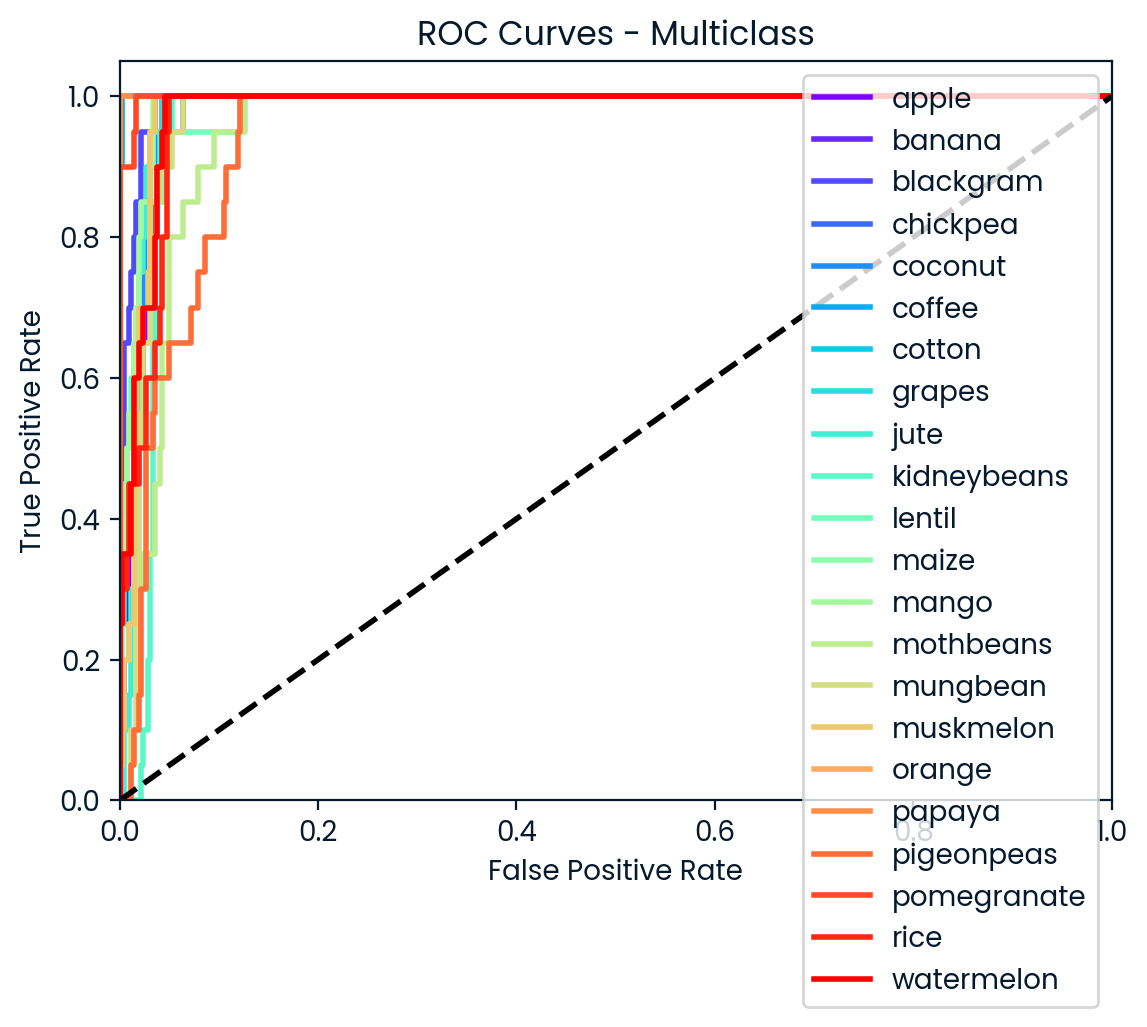

In [134]:
# libs
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

# using the best model to find the importance of features
y_pred_proba =grid_cv.best_estimator_.predict_proba(X_test)

# binarized output 
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

print("roc_auc scores are:\n")

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"{class_names[i]} = {roc_auc[i]:.2f}")

# ROC curves
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, n_classes))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=class_names[i])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multiclass')
plt.legend()
plt.show()

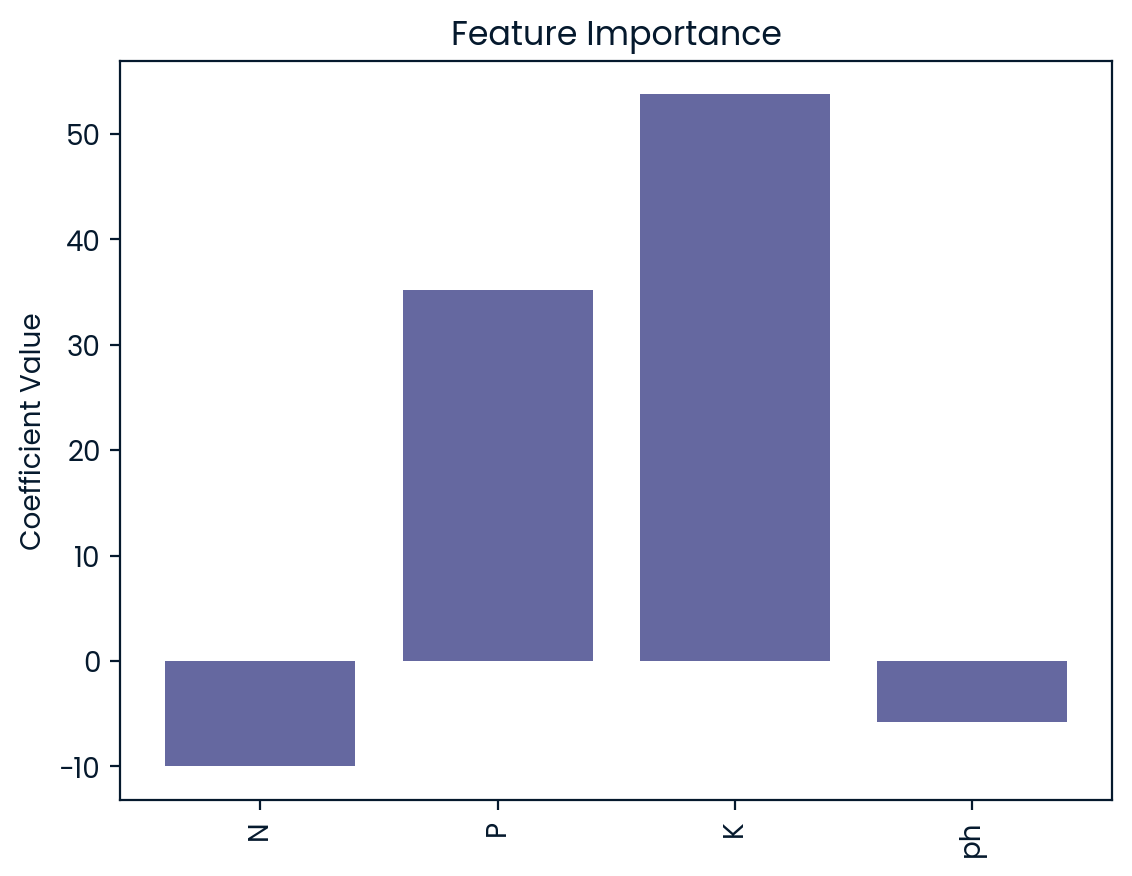

{'K': 53.74735358419984}


In [135]:
# plotting the importance
plt.bar(X.columns, grid_cv.best_estimator_.named_steps['logreg'].coef_[0])
plt.xticks(rotation=90)
plt.ylabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

best_predictive_feature = {'K':grid_cv.best_estimator_.named_steps['logreg'].coef_[0].max()}
print(best_predictive_feature)